# Exploración de hiperparámetros

In [1]:
import pandas as pd
import numpy as np
pd.set_option("max_rows", None)
from os import listdir
from os.path import isfile, join
import re
import os
import sys
import json
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})
tab_c = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink',
         'tab:gray','tab:olive','tab:cyan']

from MCMC_steiner_tree import Annealing, pre_pros, plot_graph_by_edges, Trans, weight, Annealing, read_stp, check_steiner_tree, Kruskal

In [2]:
root = {
    "main": "",  # "/Proyecto Sim. Est.",
    "data":"I080/",
    "data_I320":"/I320/",
    "sols": "bnb/solutions/" 
}

## Importando resultados

In [3]:
f = open('gridsearch/gridsearch.json')
grid_search = json.load(f)
print(grid_search)
f.close()

{'a': [0.5, 0.875, 1.25, 1.625, 2.0], 'b': [0.0, 0.25, 0.5, 0.75, 1.0]}


In [4]:
f = open('gridsearch/params.json')
params = json.load(f)
print(params)
f.close()

{'nf': 3000, 'save_rate': 5, 'repeat': 10}


In [5]:
stp_names = ['i080-001.stp', 'i080-011.stp', 'i080-021.stp', 'i080-031.stp', 'i080-041.stp', 'i080-101.stp',
             'i080-111.stp', 'i080-121.stp', 'i080-131.stp', 'i080-141.stp', 'i080-201.stp', 'i080-211.stp',
             'i080-221.stp', 'i080-231.stp', 'i080-241.stp', 'i080-301.stp', 'i080-311.stp', 'i080-321.stp',
             'i080-331.stp', 'i080-341.stp']

In [6]:
df_opt = pd.read_excel('Testset_I320.xlsx', sheet_name="I080")
df_opt = df_opt.set_index("Name")
df_opt.head()

,|V|,|E|,|T|,DC,time,Opt
Name,,,,,,
i080-001,80,120,6,P,s,1787
i080-002,80,120,6,P,s,1607
i080-003,80,120,6,P,s,1713
i080-004,80,120,6,P,s,1866
i080-005,80,120,6,P,s,1790


In [7]:
with open('gridsearch/UNIFORMS.pickle', 'rb') as handle:
    uniforms = pickle.load(handle)

In [8]:
methods = ['BFS_node','DFS_node']
a_values = grid_search['a']
b_values = grid_search['b']
len_U = len(uniforms)

In [9]:
class grafo_resultado(object):
    def __init__(self,name,len_U,df=df_opt,folder=root['main']+root['data']):
        name = name if not '.stp' in name else name.replace('.stp','')
        df_edges_G, terminals = read_stp(folder+name+'.stp')
        _, _, dic_edges, _ = pre_pros(df_edges_G)
        self.id = name
        self.terminals = terminals
        self.dic_edges = dic_edges
        self.opt = df['Opt'][name]
        self.size = int(df['|V|'][name])
        self.length = int(df['|E|'][name])
        self.difficulty = df['DC'][name]
        self.time = df['time'][name]
        self._results_loaded = False
        self._weights_computed = False
        self.len_U = len_U
        self.density = 2*self.length/(self.size*(self.size-1))
    
    @staticmethod
    def load_cm_path(path):
        with open(path, 'rb') as handle:
            return pickle.load(handle)
        
    def get_results(self,methods,a_values=grid_search['a'],b_values=grid_search['b']):
        results = {}
        times = {}
        for m in methods:
            results[m] = {}
            times[m] = {}
            for i, a in enumerate(a_values):
                results[m][a] = {}
                times[m][a] = {}
                for j, b in enumerate(b_values):
                    results[m][a][b] = {}
                    times[m][a][b] = {}
                    for l in range(self.len_U):
                        file = 'gridsearch/{}/{}_ixa={}_ixb={}_ixu={}_CM.pickle'.format(self.id,m,i,j,l)
                        results[m][a][b][l] = self.load_cm_path(file)
                        file = 'gridsearch/{}/{}_ixa={}_ixb={}_ixu={}_times.pickle'.format(self.id,m,i,j,l)
                        times[m][a][b][l] = self.load_cm_path(file)
        self.results = results
        self.times = times
        self._results_loaded = True
    
    def compute_weight_cm(self):
        weight_cm = {}
        weight_avg, weight_std, weight_min, weight_max = {}, {}, {}, {}
        for m in methods:
            weight_cm[m] = {}
            weight_avg[m], weight_std[m] = {}, {}
            weight_min[m], weight_max[m] = {}, {}
            for a in a_values:
                weight_cm[m][a] = {}
                weight_avg[m][a], weight_std[m][a] = {}, {}
                weight_min[m][a], weight_max[m][a] = {}, {}
                for b in b_values:
                    weight_cm[m][a][b] = {}
                    weight_avg[m][a][b], weight_std[m][a][b] = {}, {}
                    weight_min[m][a][b], weight_max[m][a][b] = {}, {}
                    for l in range(self.len_U):
                        weight_cm[m][a][b][l] = [weight(x, self.dic_edges) for x in self.results[m][a][b][l]]
                    weight_avg[m][a][b], weight_std[m][a][b] = self.avg_weights(weight_cm[m][a][b])
                    weight_min[m][a][b], weight_max[m][a][b] = self.min_max_weights(weight_cm[m][a][b])
        self.weight_cm = weight_cm
        self.weight_avg = weight_avg
        self.weight_std = weight_std
        self.weight_min = weight_min
        self.weight_max = weight_max
        self._weights_computed = True
        self.compute_weight_final()
    
    @staticmethod
    def avg_weights(weights_unif):
        N = len(weights_unif)
        weights_unif = np.array(list(weights_unif.values()))
        weights_avg = np.mean(weights_unif,axis=0)
        weights_std = np.std(weights_unif,axis=0)
        return list(weights_avg), list(weights_std)
    
    @staticmethod
    def min_max_weights(weights_unif):
        N = len(weights_unif)
        weights_unif = np.array(list(weights_unif.values()))
        weights_min = np.min(weights_unif,axis=0)
        weights_max = np.max(weights_unif,axis=0)
        return list(weights_min), list(weights_max)
    
    def compute_weight_final(self):
        weight_final = {}
        for m in methods:
            weight_final[m] = {}
            for a in a_values:
                weight_final[m][a] = {}
                for b in b_values:
                    weight_final[m][a][b] = {}
                    for l in range(self.len_U):
                        if self._weights_computed:
                            weight_final[m][a][b][l] = self.weight_cm[m][a][b][l][-1]
                        else:
                            x = self.results[m][a][b][l][-1]
                            weight_final[m][a][b][l] = weight(x, self.dic_edges)
        self.weight_final = weight_final

---

In [10]:
dic_grafos = {}
for grafo_id in stp_names[0:1]:
    grafo = grafo_id[:-4]
    print(grafo)
    grafo_result = grafo_resultado(grafo,len_U)
    grafo_result.get_results(methods)
    grafo_result.compute_weight_cm()
    dic_grafos[grafo] = grafo_result

i080-001


In [11]:
stp_name = stp_names[0]
df_edges_G, terminals = read_stp("I080/"+stp_name)
df_G, dic_incidence, dic_edges, G = pre_pros(df_edges_G)
V = set(df_G.index)

In [12]:
dic_grafos["i080-001"].opt

1787

In [13]:
x0, _, NB_x0 = Kruskal(V, dic_edges)
x, NB_x = x0, NB_x0

In [14]:
w0 = weight(x, dic_edges)
w0

8562

In [15]:
diff_weight_neighbords_init = []
for _ in range(1000):    
    v = np.random.uniform()
    y, NB_y = Trans(v, x, NB_x, df_G, dic_edges, terminals, False, "DFS", "Node", "")
    w = weight(y, dic_edges)
    diff_weight_neighbords_init.append(w-w0)
y0, NB_y0 = y, NB_y
w0 = w

(array([ 22.,  82., 101., 114., 596.,  50.,  27.,   5.,   1.,   2.]),
 array([-6412. , -6209.9, -6007.8, -5805.7, -5603.6, -5401.5, -5199.4,
        -4997.3, -4795.2, -4593.1, -4391. ]),
 <BarContainer object of 10 artists>)

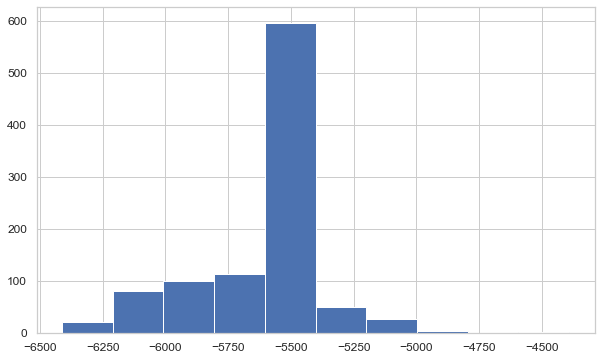

In [16]:
plt.hist(diff_weight_neighbords_init)

In [17]:
diff_weight_neighbords_rand = []
for _ in range(1000):    
    v = np.random.uniform()
    y, NB_y = Trans(v, y0, NB_y0, df_G, dic_edges, terminals, False, "DFS", "Node", "Kruskal")
    w = weight(y, dic_edges)
    diff_weight_neighbords_rand.append(w-w0)
y0, NB_y0 = y, NB_y
w0 = w

(array([ 52.,  88.,  49., 502., 165.,  79.,  39.,  17.,   7.,   2.]),
 array([-560. , -405.4, -250.8,  -96.2,   58.4,  213. ,  367.6,  522.2,
         676.8,  831.4,  986. ]),
 <BarContainer object of 10 artists>)

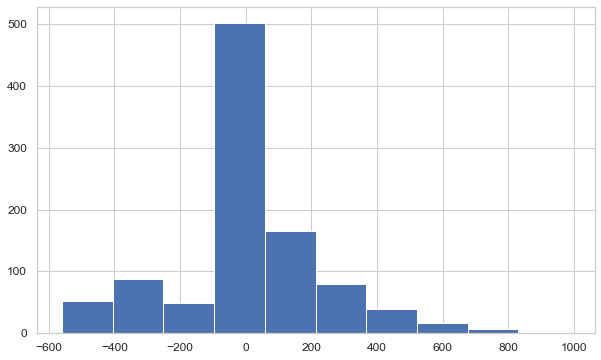

In [18]:
plt.hist(diff_weight_neighbords_rand)

In [21]:
NB_y

{9: [20, 17, 4],
 20: [9, 7, 10],
 7: [20, 76],
 12: [67, 57],
 67: [12, 76],
 46: [75, 55],
 75: [46, 34],
 76: [67, 7],
 36: [57, 3],
 57: [36, 12],
 10: [20, 5],
 17: [70, 9],
 70: [17, 6],
 34: [56, 75, 1],
 56: [34, 79],
 79: [56, 2],
 21: [60, 55],
 60: [21, 6],
 55: [46, 21],
 2: [79],
 6: [70, 60],
 5: [10],
 1: [34],
 4: [9],
 3: [36]}

In [22]:
y

[[9, 20],
 [7, 20],
 [12, 67],
 [46, 75],
 [67, 76],
 [36, 57],
 [10, 20],
 [17, 70],
 [7, 76],
 [34, 56],
 [12, 57],
 [34, 75],
 [56, 79],
 [9, 17],
 [21, 60],
 [46, 55],
 [21, 55],
 [2, 79],
 [6, 70],
 [5, 10],
 [1, 34],
 [4, 9],
 [6, 60],
 [3, 36]]

In [34]:
NB_y = {}
for e in y:
    a, b = e
    for xa in [a, b]:
        if xa not in NB_y:
            NB_y[xa] = []
        
        xb = [a, b][a==xa]
        if xb not in NB_y[xa]:
            NB_y[xa].append(xb)

In [35]:
NB_y

{9: [20, 17, 4],
 20: [9, 7, 10],
 7: [20, 76],
 12: [67, 57],
 67: [12, 76],
 46: [75, 55],
 75: [46, 34],
 76: [67, 7],
 36: [57, 3],
 57: [36, 12],
 10: [20, 5],
 17: [70, 9],
 70: [17, 6],
 34: [56, 75, 1],
 56: [34, 79],
 79: [56, 2],
 21: [60, 55],
 60: [21, 6],
 55: [46, 21],
 2: [79],
 6: [70, 60],
 5: [10],
 1: [34],
 4: [9],
 3: [36]}

In [36]:
{9: [20, 17, 4],
 20: [9, 7, 10],
 7: [20, 76],
 12: [67, 57],
 67: [12, 76],
 46: [75, 55],
 75: [46, 34],
 76: [67, 7],
 36: [57, 3],
 57: [36, 12],
 10: [20, 5],
 17: [70, 9],
 70: [17, 6],
 34: [56, 75, 1],
 56: [34, 79],
 79: [56, 2],
 21: [60, 55],
 60: [21, 6],
 55: [46, 21],
 2: [79],
 6: [70, 60],
 5: [10],
 1: [34],
 4: [9],
 3: [36]}

{9: [20, 17, 4],
 20: [9, 7, 10],
 7: [20, 76],
 12: [67, 57],
 67: [12, 76],
 46: [75, 55],
 75: [46, 34],
 76: [67, 7],
 36: [57, 3],
 57: [36, 12],
 10: [20, 5],
 17: [70, 9],
 70: [17, 6],
 34: [56, 75, 1],
 56: [34, 79],
 79: [56, 2],
 21: [60, 55],
 60: [21, 6],
 55: [46, 21],
 2: [79],
 6: [70, 60],
 5: [10],
 1: [34],
 4: [9],
 3: [36]}

In [46]:
stp_name = "i080-001.stp"
df_edges_G, terminals = read_stp("I080/"+stp_name)
df_G, dic_incidence, dic_edges, G = pre_pros(df_edges_G)

median_weight = df_edges_G["WEIGHT"].median()

In [104]:
save_rate = 1
a = 1
b = 0.25
params["nf"] = 5000
annealing = Annealing(
                            nf=params["nf"],
                            beta=[a * (n ** b) * (1 / median_weight) for n in range(params["nf"])],
                            df_NB_G=df_G,
                            dic_weight_edges=dic_edges,
                            terminals=terminals,
                            greedy=False,
                            path_approach="DFS",
                            remove_approach="Node"
)
U, V = uniforms[0]
annealing.MCMC(U, V, save_rate=save_rate)

In [105]:
weight(annealing.CM[-1], dic_edges)

1787

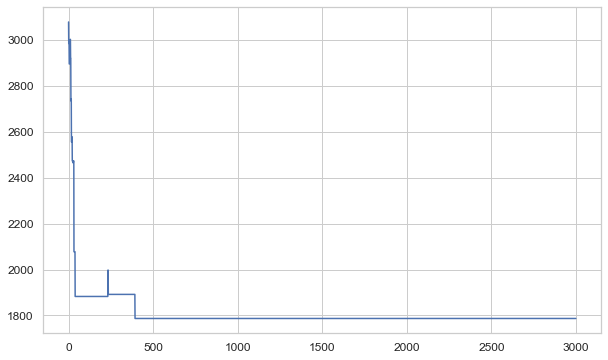

In [106]:
plt.plot(range(len(annealing.CM[1:])), [weight(x, dic_edges) for x in annealing.CM[1:]])